In [1]:
%matplotlib inline
import copy
import scipy as sp
import numpy as np
import networkx as nx
from networkx.generators.trees import NIL
import matplotlib.pyplot as plt
from random_word import RandomWords
from collections import defaultdict as ddict
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import seaborn as sns; sns.set()

In [2]:
def sqdist(X1, X2):
    """ Given two matrices whose rows are points, computes the distances
    between all the points of the first matrix and all the points of the
    second matrix

    Arguments:
    X1: [N1 x d], earch row is a d-dimensional point
    X2: [N2 x d], each row is a d-dimensional point

    Returns:
    M: [N1 x N2], each element  is the distance between two points
    M_ij = || X1_i - X2_j ||"""

    if not isinstance(X1, np.ndarray):
        X1 = np.array(X1)
    if not isinstance(X2, np.ndarray):
        X2 = np.array(X2)
    if X1.ndim <= 1:
        sqx         = np.array(X1*X1, dtype=np.float32)
        rows_X1     = 1
    else:
        sqx = np.sum(np.multiply(X1, X1), 1)
        rows_X1     = sqx.shape[0]

    if X2.ndim <= 1:
        sqy         = np.array(X2*X2, dtype=np.float32)
        rows_X2     = 1
    else:
        sqy = np.sum(np.multiply(X2, X2), 1)
        rows_X2     = sqy.shape[0]
    X1_squares      = np.squeeze(np.outer(np.ones(rows_X1), sqy.T))
    X2_squares      = np.squeeze(np.outer(sqx, np.ones(rows_X2)))
    double_prod     = np.squeeze(2 * np.dot(X1,X2.T))

    return X1_squares + X2_squares - double_prod

In [3]:
def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, 
                  pos = None, parent = None):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node of current branch
       width: horizontal space allocated for this branch - avoids overlap with other branches
       vert_gap: gap between levels of hierarchy
       vert_loc: vertical location of root
       xcenter: horizontal location of root
       pos: a dict saying where all nodes go if they have been assigned
       parent: parent of this branch.'''
    if pos == None:
        pos = {root:(xcenter,vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    neighbors = list(G.neighbors(root)) 
    if parent != None:   #this should be removed for directed graphs.
        neighbors.remove(parent)  #if directed, then parent not in neighbors.
    if len(neighbors)!=0:
        dx = width/len(neighbors) 
        nextx = xcenter - width/2 - dx/2
        for neighbor in neighbors:
            nextx += dx
            pos = hierarchy_pos(G,neighbor, width = dx, vert_gap = vert_gap, 
                                vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                parent = root)
    return pos

In [5]:
def add_children(G, nodesToIter, nidx, fomax=10, fomin=0):
    #print("Nodes to iter:", nodesToIter)
    new_nodes =[]
    for node in nodesToIter:
        nchildren = np.random.randint(fomin, fomax+1)        
        if nchildren == 0:
            continue
        current_new_nodes = range(nidx, nidx+nchildren)
        new_nodes += current_new_nodes
        new_edges = [(node, x) for x in current_new_nodes]
        #print('Iterating over node %d'  %   node)
        #print(new_edges)
        G.add_edges_from(new_edges)
        nidx += nchildren
        #print("Node: %d, nchildren %d, nidx %d" % (node, nchildren, nidx))
    
    return G, nidx, new_nodes



Depth 0

Depth 1

Depth 2
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]


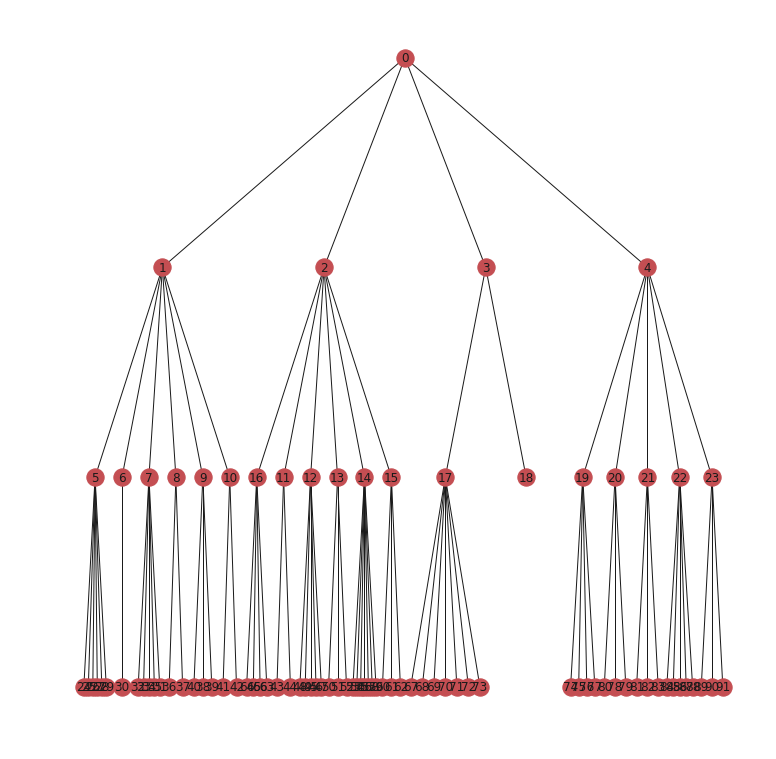

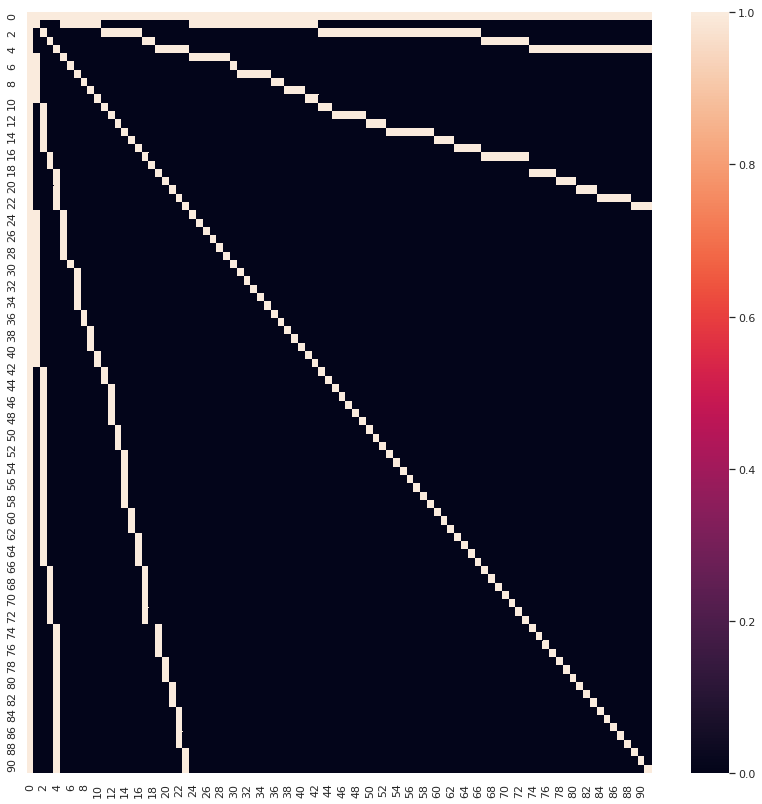

In [6]:
## Generate graph of max depth selected bu yser
fanout1 = 10
fanout2 = 8

nidx = 1
max_depth = 3
DG = nx.DiGraph()
root = 0
DG.add_node(root)
nodesToIter = [root]
nodelist = [root]

for depth in range(max_depth):
    if depth == 0:
        fomin = 3
        fomax=6
    else:
        if np.random.random() > 0.1:
            fomax= int(8 -(depth/2))
        else: 
            fomax = 8
        if np.random.random() > 0.1:
            fomin = 0
        else:
            fomin= fomax-1
    DG, nidx, nodesToIter = add_children(DG, nodesToIter, nidx, fomax=fomax, fomin=fomin)
    nodelist += nodesToIter
    print("\nDepth", depth)
print(nodelist)
pos = hierarchy_pos(nx.to_undirected(DG),root)
plt.figure(figsize=(10,10))
nx.draw(nx.to_undirected(DG), pos=pos, with_labels=True)

nodes = [node for node in DG.nodes]
for node in nodes:
    DG.add_node(node, label=str(node), feature=node) 



C = nx.DiGraph.reverse(nx.transitive_closure(DG))
O = nx.DiGraph.reverse(DG)
A = nx.adj_matrix(nx.to_undirected(nx.transitive_closure(DG)), nodelist)
F = nx.adj_matrix(nx.transitive_closure(nx.reverse((DG))), nodelist)
# A = nx.adj_matrix(nx.to_undirected(DG), nodelist)

A = sp.sparse.csc_matrix.todense(A) + np.eye(A.shape[0])
F = sp.sparse.csc_matrix.todense(F) + np.eye(F.shape[0])

plt.figure(figsize=(14,14))
ax = sns.heatmap(A)

nx.write_edgelist(C, "../data/toy_simple_closed.tsv", delimiter='\t', data=False)
nx.write_gpickle(C, '../data/toy_simple_closed.p')
nx.write_edgelist(O, "../data/toy_simple_open.tsv", delimiter='\t', data=False)
nx.write_gpickle(O, '../data/toy_simple_open.p')
np.save('../data/adjacency_matrix.npy', A)
np.save("../data/toy_features.npy", F)


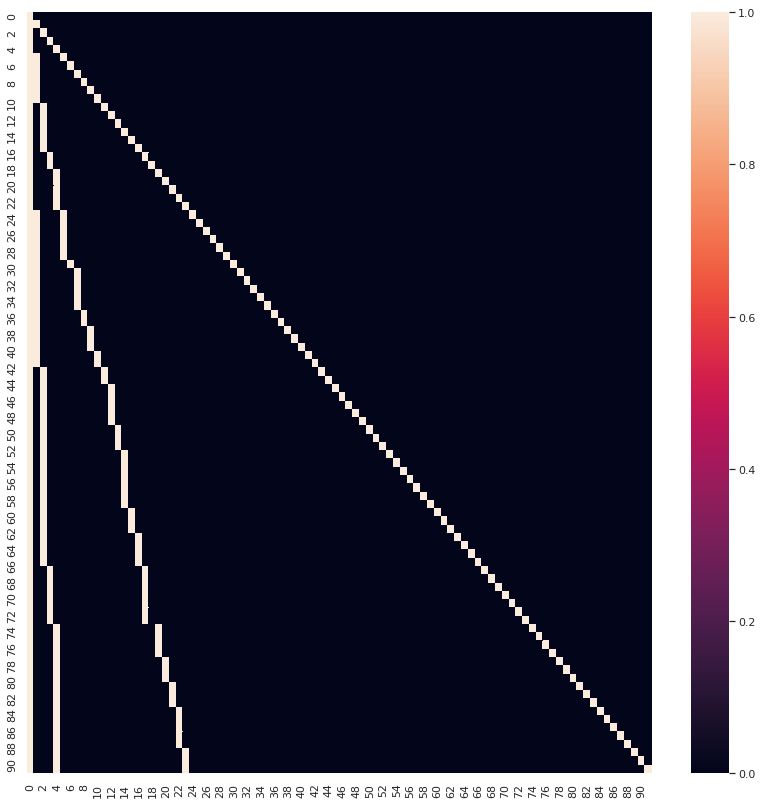

In [8]:
plt.figure(figsize=(14,14))
ax = sns.heatmap(F)

In [38]:
print(np.argsort(D[101]))

[101  16  99  98   3  97  96  95 100  15  14  13   0  81  83  84  85  86
  87  88  89  90  91  82  92  94  79  78  77   2   1  76  75  93  80   7
  11   6   5   4   8   9  12  10  61  62  63  64  65  66  69  68  70  71
  72  73  74  67  60  57  58  33  32  31  30  29  28  27  26  25  24  23
  22  21  20  19  18  17  34  35  36  37  56  55  54  53  52  51  49  48
  59  47  45  44  43  42  41  40  39  38  46  50]


In [56]:
for n in nx.to_undirected(O).neighbors(11):
    print(n)

64
65
2
66
67
68
62
63


In [3]:
plt.figure(figsize=(14,14))
ax = sns.heatmap(A)

NameError: name 'A' is not defined

<Figure size 1008x1008 with 0 Axes>

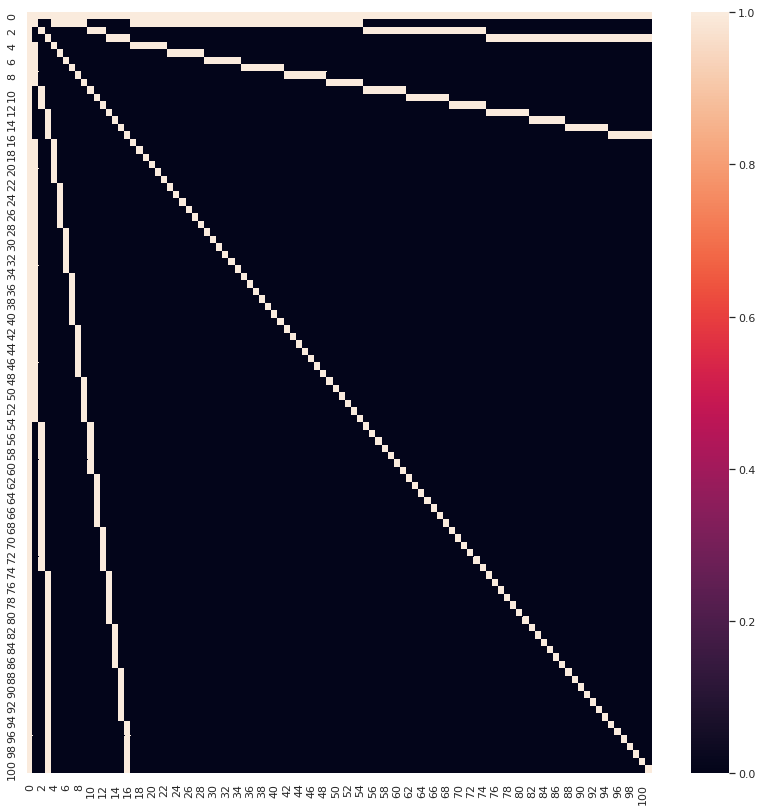

In [4]:
A = np.load('../data/adjacency_matrix.npy')
F = np.load("../data/toy_features.npy")
O = nx.read_gpickle('../data/toy_simple_open.p')


plt.figure(figsize=(14,14))
ax = sns.heatmap(A)


In [7]:
### Add a random number of leaves to each leaf, creating a feature vector for each leaf
start_nnodes = DG.number_of_nodes()
leaves_idx = DG.number_of_nodes()
gen_instances = True
max_child = 5
dim = 100

X = []
instances_list = []
nodes = [node for node in DG.nodes]
for node in nodes:
    DG.add_node(node, label=str(node), feature=-1) 
    if gen_instances and len(list(DG.successors(node))) == 0 and (node != root):
        nchildren = np.random.randint(1, max_child+1)
        mean = np.zeros(dim)
        mean[min(dim-1, leaves_idx-start_nnodes)] = 10
        for child in range(nchildren):
            childname = str(node)+'_'+str(child)
            DG.add_node(childname, label=str(node), feature=(leaves_idx-start_nnodes))
            DG.add_edge(node, childname)feature=
            instances_list.append(childname)
            leaves_idx += 1
            feature = np.random.multivariate_normal(mean=mean, cov=np.eye(mean.size))
            X.append(feature)
        print("Added %d leaves to node %s" % (nchildren, node))
X = np.asarray(X)
print("\nAdded %d leaves" % (leaves_idx - start_nnodes))
GDC = nx.transitive_closure(GD)
nodes  = [node[0] for node in U.adjacency()]
plt.figure(figsize=(8,8))
pos = hierarchy_pos(U,'root')    
nx.draw(U, pos=pos, with_labels=True)

Added 3 leaves to node 6
Added 5 leaves to node 8
Added 5 leaves to node 20
Added 2 leaves to node 27
Added 2 leaves to node 28
Added 3 leaves to node 29
Added 1 leaves to node 30
Added 5 leaves to node 31
Added 1 leaves to node 32
Added 1 leaves to node 33
Added 2 leaves to node 34
Added 4 leaves to node 35
Added 4 leaves to node 36
Added 1 leaves to node 37
Added 3 leaves to node 38
Added 5 leaves to node 39
Added 3 leaves to node 40
Added 4 leaves to node 41
Added 2 leaves to node 42
Added 2 leaves to node 43
Added 2 leaves to node 44
Added 3 leaves to node 45
Added 1 leaves to node 46
Added 4 leaves to node 47
Added 5 leaves to node 48
Added 5 leaves to node 49
Added 4 leaves to node 50
Added 1 leaves to node 51
Added 5 leaves to node 52
Added 5 leaves to node 53
Added 2 leaves to node 54
Added 2 leaves to node 55
Added 2 leaves to node 56
Added 4 leaves to node 57
Added 5 leaves to node 58
Added 4 leaves to node 59
Added 3 leaves to node 60
Added 2 leaves to node 61
Added 1 leaves

NameError: name 'GD' is not defined

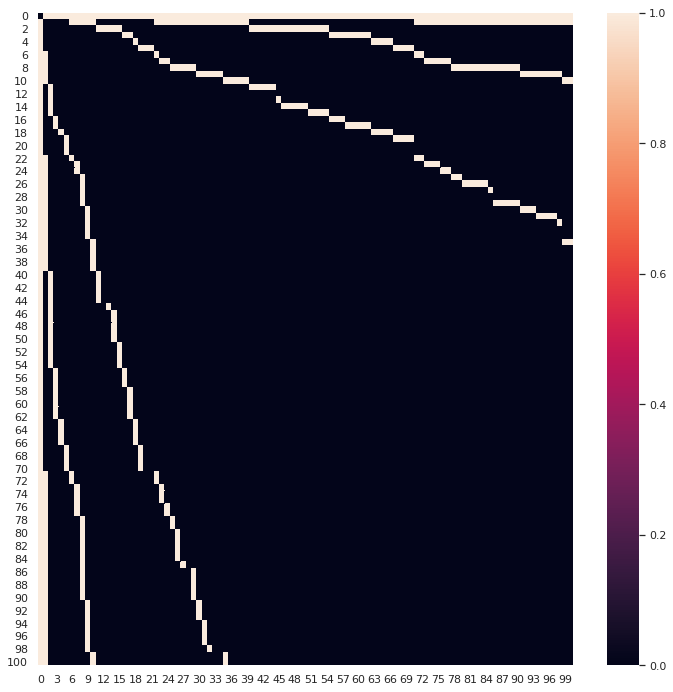

In [27]:
U = nx.transitive_closure(DG)
F = nx.to_undirected(U)
A = nx.adj_matrix(F, nodelist)
A = sp.sparse.csc_matrix.todense(A)
plt.figure(figsize=(12,12))
ax = sns.heatmap(A)

In [12]:
K = np.dot(X,X.T)
print(K.shape)
plt.figure(figsize=(6,6))
ax = sns.heatmap(K)

(97, 97)


<Figure size 432x432 with 2 Axes>

In [28]:
if gen_instances:
    nx.write_weighted_edgelist(F, "../data/synth_instances.tsv", delimiter='\t')
    nx.write_gpickle(F, '../data/synth_instances.p')
    np.save("../data/synth_features.npy", X)
else:
    nx.write_weighted_edgelist(F, "../data/synth_simple.tsv", delimiter='\t')
    nx.write_gpickle(F, '../data/synth_simple.p')

NameError: name 'gen_instances' is not defined

### Generate random tree with nx function

In [87]:
for s in O.predecessors(3):
    print(s)

86
4
99


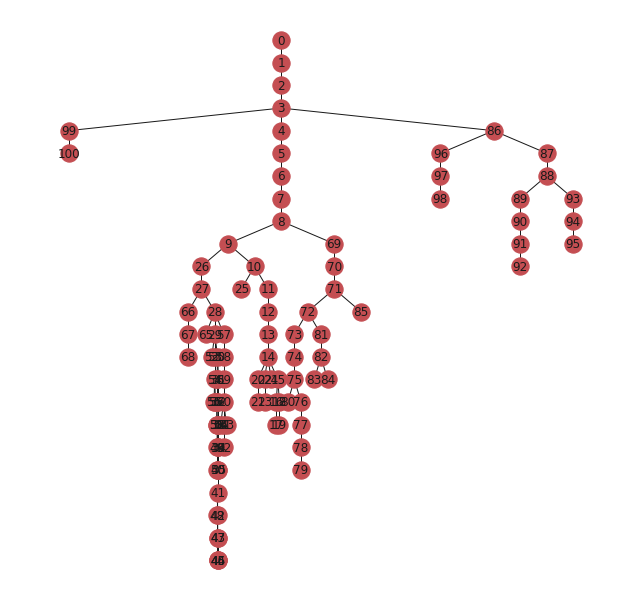

In [103]:
root_init=0
G = nx.random_tree(100, 24)
# plt.figure(figsize=(8,8))
# pos = hierarchy_pos(G,root_init)
# nx.draw(G, pos=pos, with_labels=True)

paths=[]
names={}
nodelist = []
nodelist.append(0)

for target in G.nodes:
    for path in nx.all_simple_paths(G, source=root_init, target=target):
        paths.append(path)
GD, root = nx.prefix_tree(paths)
GD.remove_node(NIL)
for idx, node in enumerate(nx.dfs_preorder_nodes(GD, source=root)):
    if node == root:
        continue
    names[node] = idx
    nodelist.append(idx)
names[root] = 0
root =  names[root]
GD = nx.relabel_nodes(GD, names, copy=False)

C = nx.DiGraph.reverse(nx.transitive_closure(GD))
O = nx.DiGraph.reverse(GD)
A = nx.adj_matrix(nx.to_undirected(nx.transitive_closure(GD)), nodelist)
A = sp.sparse.csc_matrix.todense(A)
plt.figure(figsize=(8,8))
pos = hierarchy_pos(nx.to_undirected(GD),root)    
nx.draw(nx.to_undirected(GD), pos=pos, with_labels=True)

nx.write_edgelist(C, "../data/toy_simple_closed.tsv", delimiter='\t', data=False)
nx.write_gpickle(C, '../data/toy_simple_closed.p')
nx.write_edgelist(O, '../data/toy_simple.open.tsv', delimiter='\t', data=False)
np.save("../data/toy_features.npy", A)

In [108]:
for s in C.predecessors(86):
    print(s)

87
96
88
89
90
91
92
93
94
95
97
98


In [118]:
L = nx.read_edgelist('../data/london_geonames_open.tsv', create_using=nx.DiGraph())
L = nx.reverse(L)
L = nx.transitive_closure(L)
L = nx.reverse(L)
nx.write_edgelist(L, '../data/london_geonames_closed.tsv', delimiter='\t', data=False)


In [115]:
L.nodes()

NodeView(('Class', 'ConceptScheme', 'Code', 'Concept', 'GeonamesFeature', 'Feature', 'Place', 'Map', 'Document', 'RDFData', 'WikipediaArticle', 'A', 'H', 'L', 'P', 'R', 'S', 'T', 'U', 'V', 'EST', 'PPLA3', 'PPL', 'CMN', 'PPLX', 'RSTN', 'MTRO', 'STM', 'ADM3', 'BDG', 'LOCK', 'RDA', 'TNL', 'PRK', 'ST', 'PT', 'PPLC', 'PRSH', 'AREA', 'ADM2', 'FRST', 'PAL', 'RCH', 'LCTY', 'RSTNQ', 'CH', 'CSTL', 'TOWR', 'STDM', 'HSP', 'OBS', 'AIRP', 'STNM', 'HTL', 'BCN', 'HSTS', 'OBPT', 'PPLL', 'THTR', 'MUS', 'BLDG', 'RDJCT', 'MALL', 'CTRR', 'MKT', 'MNMT', 'BRKS', 'TNLRD', 'SQR', 'CTHSE', 'BANK', 'UNIV', 'OPRA', 'STNR', 'RD', 'CTRB', 'ISL', 'CTRCM', 'HSE', 'HSPC', 'LIBR', 'SCH', 'LK', 'STMSB', 'CMTY', 'PO', 'ATM', 'ZN', 'PRN', 'MLWND', 'REST', 'ARCHV', 'PP', 'BUSTN', 'PS', 'RJCT', 'ADMF', 'FCL', 'FY', 'RUIN', 'SWT', 'TNLRR', 'ADM4', 'SCHC', 'MVA', 'ADM1H', 'RYD', 'BLDO', 'PPLA4', 'HLL', 'MDW', 'PND', 'DCKY', 'DCKD', 'ATHF', 'RSV', 'MRSH', 'MAR', 'HTH', 'RECG', 'PRKGT', 'RESF', 'GRVE', 'AIRH', 'WTRC', 'GDN', 'P

In [122]:
L = nx.read_edgelist('../data/london_geonames_open.tsv', create_using=nx.DiGraph())
L = nx.transitive_closure(L)
nx.write_edgelist(L, '../data/london_geonames_closed.tsv', delimiter='\t', data=False)


In [34]:
a = np.outer(np.arange((10)), np.ones(10))

In [35]:
a

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [6., 6., 6., 6., 6., 6., 6., 6., 6., 6.],
       [7., 7., 7., 7., 7., 7., 7., 7., 7., 7.],
       [8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.]])

In [40]:
a[np.random.choice(10, 10)]

array([[5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [6., 6., 6., 6., 6., 6., 6., 6., 6., 6.],
       [6., 6., 6., 6., 6., 6., 6., 6., 6., 6.],
       [6., 6., 6., 6., 6., 6., 6., 6., 6., 6.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [6., 6., 6., 6., 6., 6., 6., 6., 6., 6.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [6., 6., 6., 6., 6., 6., 6., 6., 6., 6.]])